<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="../1_OSI_SAF_sst_introductory/1_1a_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb" target="_blank"><< OSI SAF sea surface temperature Introductory</a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2025 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sst/HEAD?labpath=1_OSI_SAF_sst_introductory%2F1_1b_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea surface temperature: SST use case</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
- **<a href="https://osi-saf.eumetsat.int/register" target="_blank">A EUMETSAT OSI SAF account</a>** if you are using or plan to use the EUMETSAT OSI SAF data.
    
- **<a href="https://data.marine.copernicus.eu/register?redirect=%2Fproduct%2FSST_GLO_SST_L4_REP_OBSERVATIONS_010_024%2Ffiles%3Fpath%3DSST_GLO_SST_L4_REP_OBSERVATIONS_010_024%252FC3S-GLO-SST-L4-REP-OBS-SST_202506%252F" target="_blank">A COPERNICUS account</a>** if you are using or plan to use the COPERNICUS data to create the climatology by yourself.

There are no prerequisite notebooks for this module.
</div>
<hr>

# 2.1 Use case : Mapping OSI SAF Meteosat SST deviations from a climatology
### Data used 

| Dataset | Collection ID | Website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Meteosat Sea Surface Temperature | EO:EUM:DAT:METEOSAT:OSIHSST-NC | <a href="https://osi-saf.eumetsat.int/products/osi-206-a" target="_blank">Description</a>| OSI-206-a | 
| ESA Sea Surface Temperature Climate Change Initiative (SST_cci): Climatology product, version 3.0 | / | <a href="https://doi.org/10.5285/62800d3d2227449085b430b503d36b01" target="_blank">Description</a>| / | 



### Learning outcomes

At the end of this notebook you will know;
* How to open Meteosat SST netcdf
* Select and Map SST from different files on a single map
* Compare satellite data with an climatology
* Map the SST deviations

### Outline

This notebook presents a method to analyze the **daily sea surface temperature (SST) deviations from a climatic mean** using satellite and climatological data. The goal is to identify regions where measured temperatures deviate from the seasonal average for this date, enabling detection of unusual phenomena such as unsual heat wave/cold spell.

An SST anomaly represents the difference between the **observed sea surface temperature and the expected average** for a specific date.

The data used include:

   - 24 hourly geostationnary satellite files dated from 30 June 2025.
   
   - A climatology providing the average SST for every 30 of June over the last climatological period -3 decades (1991-2020).

To avoid diurnal warming effect, we will select nighttime measurement based on the solar zenith angle.

The final output **is a SST deviation to the climatology map** (in °C|K), highlighting areas where SSTs differ from the climatological norm.

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Creating our workspace](#section1)
 1. [Setting login information](#section2)
 1. [Download the Near Real Time satellite data](#section3)
 1. [Open the data files](#section4)
 1. [Getting the daily SST](#section5)
 1. [Mapping the SST](#section6)
 1. [Mapping the SST anomalies](#section7)
 


<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Creating the workspace
[Back to top](#TOC-TOP)

</div>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library import 
import numpy as np                 # for numerical operations and multi-dimensional arrays
import xarray as xr                # for working with labeled multi-dimensional datasets (e.g., NetCDF)
from netCDF4 import Dataset        # lower-level alternative to xarray for reading/writing NetCDF files
import matplotlib.pyplot as plt    # for plotting graphs and data visualizations
import matplotlib.cm as mpl_cm     # for accessing color maps for plots
import cartopy.crs as ccrs         # for map projections and geographic coordinate systems
import cartopy.feature as cfeature # for adding geographic features like coastlines, borders, etc.
import os                          # for interacting with the file system (paths, folders, etc.)
import shutil                      # for moving, copying, or deleting files and directories
import urllib                      # for handling URLs and downloading data from the internet
import ftplib                      # for connecting to FTP servers and downloading files
import datetime                    # for manipulating dates and timestamps
import json                        # for reading and writing JSON format data

Next we will create a download directory to store the data we need for this notebook.

In [2]:
# create a folder
download_dir = os.path.join(os.getcwd(), "data")
os.makedirs(download_dir, exist_ok=True)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Setting login information
[Back to top](#TOC-TOP)

</div>

We will access OSI SAF data from the OSI SAF Lower-Mid-Latitude Centre FTP server.

In order to allow us to download data, we need to provide our credentials. We can do this in two ways; either by creating a file called `.eumetsat_osi_saf_sst_credentials` in our home directory (*option 1 - recommended*) or by supplying our credentials directly in this script (*option 2*). 

#### Option 1: creating  `.eumetsat_osi_saf_sst_credentials` in our home directory

For most computer systems the home directory can be found at the path \user\username, /users/username, or /home/username depending on your operating system.

In this file we need to add the following information exactly as follows;

```
{
"username": "anonymous",
"password": "anonymous"
}
```

Make sure to save the file without any kind of extension.

Once you have done this, you can read in your credentials using the commands in the following cell. These will be used to generate a time-limited token, which will refresh itself when it expires.

Reading credential information.

In [3]:
# read credentials
with open(os.path.join(os.path.expanduser("~"),'.eumetsat_osi_saf_sst_credentials')) as json_file:
    credentials = json.load(json_file)

Loading credentials.

In [4]:
username = credentials['username'] 
password = credentials['password']

Option 2: provide credentials directly
You can provide your credentials directly as follows; by uncommenting the following lines.

In [5]:
#username = "provided_username"
#password = "provided_password"

You must replace provided_username and provided_password with the information provided to you after you have registered to the OSI SAF website and mentionned your interest in SST data.

Once you have created an EUMETSAT OSI SAF account, the generic password and credentials to access OSI SAF Lower-Mid-Latitude  server should have been sent to you via email.

Note: this method is convenient in the short term, but is not really recommended as you have to put your provided username and password in this notebook, and run the risk of accidentally sharing them. This method also requires you to authenticate on a notebook-by-notebook basis.

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Download the Near Real Time satellite data
[Back to top](#TOC-TOP)

</div>

In this section, we will download from OSI-SAF FTP repository. 

In order to have the more reliable SST measurement as possible, we need to avoid diurnal warming effect. That for we need to select nighttime measurements. The **geostationnary data** are the most relevant tools to achieve that, as they are providing data from the same point of Earth. We will then use the OSI SAF product issued from the satellite Meteosat-12 (formerly MTG-I1), orbiting on Meteosat 0° position. This product is hourly. We'll then download the 24 file for one day

### Meteosat Daily Sea Surface Temperature :

Let's start by creating a specific folder to hold the Meteosat Sea Surface Temperature products.

In [6]:
# create a folder
download_dir = os.path.join(os.getcwd(), "data", "L3_Meteosat_0°")
os.makedirs(download_dir, exist_ok=True)

Let's select the date. We will here take the example of the 30th June 2025.
We'll then set a few variable depending on the date, to be use as strings in file names and plot titles.

In [7]:
# select date
Year, Month, Day = 2025, 6, 30
product = 'Meteosat 0° SEVIRI SST'

Month_str = "{:02d}".format(Month)
Day_str = "{:02d}".format(Day)
Date_str = Day_str+'/'+Month_str+'/'+str(Year)
day_of_year = "{:03d}".format(datetime.datetime(Year, Month, Day).timetuple().tm_yday) # Calcul the day number of the year

print('Day of year for',Date_str,': ',day_of_year)

Day of year for 30/06/2025 :  181


Set the download path.

In [8]:
# the path where we find the netCDF files for each hour
path = '/ifremer/cersat/projects/osisaf/sst/l3c/east_atlantic_west_indian/mtg/' + str(Year) + '/' + day_of_year

We connect to the ftp and we download each 24 files, one per hour. We can print every filename to make sur there are every 24 files.

In [9]:
# connect ftp and download file
ftp = ftplib.FTP("ftp.ifremer.fr") 
ftp.login(username, password)
ftp.cwd(path)
for i in range (24):    # a loop executed 24 times in order to get netCDF files for each hour of the day ( from 00 am to 11 pm)
    Hour = i
    Hour_str = "{:02d}".format(Hour)
    # files' name we are looking for to get our SST data. Each file depend on the day and the hour. With the loop, we have access to every file from this path for the 31 august of 2024
    filename = str(Year) + Month_str + Day_str + \
    Hour_str + '0000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc'           
    print(filename)
    try:     
        ftp.retrbinary("RETR " + filename, open(os.path.join(os.getcwd(), 'data', 'L3_Meteosat_0°', filename), 'wb').write)   #réecriture des fichiers dans le dossier "global_GHRSST"
    except: 
        None
ftp.quit()   # quit the FTP

20250630000000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630010000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630020000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630030000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630040000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630050000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630060000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630070000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630080000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630090000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630100000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630110000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630120000-OSISAF-L3C_GHRSST-SSTsubskin-Meteosat12_FCI-v02.1-fv01.0.nc
20250630130000-OSISAF-L3C

'221 Goodbye.'

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Open the data files
[Back to top](#TOC-TOP)

</div>

### The climatology

We will here map the deviation for our geostationnary SST in comparison with a climatology. We are going to use a "on the shelve" 1991-2020 climatology made by a team of the University of Reading in the frame of the ESA Climat Change Initiative. This climatology, based on an ESA Climate Data Record is dedicated for works with satellite product. You can find more information about the CDR and the Climatology in the dedicated article (<a href='https://doi.org/10.1038/s41597-024-03147-w'>O.Embury et al.</a>).

To ease this notebook use, we already download the netCDF file for the 30th of June 2025 and stored it in `data/ESACCI_SST_Clim`. You can find all of the 365 days on the <a href='https://dx.doi.org/10.5285/62800d3d2227449085b430b503d36b01'>product repository</a>.

Let's open the file and read the data.

In [10]:
# load the climatology netcdf file of August 31, 2024 which corresponds to day 245 of the year
file_clim = 'data/ESACCI_SST_Clim/D'+day_of_year+'-ESACCI-L4_GHRSST-SSTdepth-Climatology-GLOB_CDR3.0-v02.0-fv01.0.nc'
print(file_clim)

# open the NetCDF climatology files from August 31, 2024 
dataset_clim = xr.open_dataset(file_clim)

data/ESACCI_SST_Clim/D181-ESACCI-L4_GHRSST-SSTdepth-Climatology-GLOB_CDR3.0-v02.0-fv01.0.nc


### The Meteosat-12 Satellite data

We are going to work with the 24 hourly files for the set date, in order to select the most representative data for our **daily** SST. We can will then gather them in a list we named "datasets" in order to use them easily after.

In [11]:
# path where the files are stored
directory = os.path.join(os.getcwd(), 'data' , 'L3_Meteosat_0°')

# creation of a "datasets" list to quickly access open files
datasets = []

# search for netCDF files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        
        # open the netCDF files
        nc = xr.open_dataset(os.path.join(directory, filename))
        
        # adding the netCDF files to the "datasets" list by adding them at the end
        datasets.append(nc)

/tmp/ipykernel_645090/122103820.py:12: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  nc = xr.open_dataset(os.path.join(directory, filename))
/tmp/ipykernel_645090/122103820.py:12: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  nc = xr.open_dataset(os.path.join(directory, filename))
/tmp/ipykernel_645090/122103820.py:12: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  nc = xr.open_dataset(os.path.join(directory, filename))
/tmp/ipykernel_645090/122103820.py:12: FutureWarning: In a future version of xarray decode_timedelta will default t

<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Getting the daily SST
[Back to top](#TOC-TOP)

</div>

The Satellite SST we downloaded is an hourly measurement of the surface temperature of the ocean. In order to create our daily deviation, we then need to deduce a daily value from our hourly files.
The OSI SAF geostationnary SST we downloaded is a retrieval of the temperature of the **subskin**. As shown in the image below, the subskin (in yellow) is the mosty sensitive layer to diurnal warming. In case of low wind condition, this global warming can raise the temperature of the few mm below the surface by several Kelvin (=degree celsius). <br>
*note: the temperatures and depth on this graph are illustrative. The real value highly depends on the situation, for the SST-SSTfnd (it can reach as far a 5K in some depth) as for the Depth for Foundation.*

<figures>
<img src='../img/Minnett&Kaiser-Weiss(2012)_SST_profiles.png' width=700 >
<br>
<figcaption>Near-surface oceanic temperature gradients <br>by <a href="https://www.ghrsst.org/wp-content/uploads/2021/04/SSTDefinitionsDiscussion.pdf" target="_blank"> Peter Minnett and Andrea Kaiser-Weiss (2012)</a></figcaption>
</figure>

In order to avoid the diurnal warming, we will here try to select nighttime values from each of our 24 file, and aggregate them. Let's have a look at vairable available.

In [12]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename),decode_timedelta=False)
		
nc

<xarray.Dataset> Size: 668MB
Dimensions:                    (time: 1, lat: 2400, lon: 2400)
Coordinates:
  * time                       (time) datetime64[ns] 8B 2025-06-30T04:00:00
  * lat                        (lat) float32 10kB -59.97 -59.92 ... 59.92 59.97
  * lon                        (lon) float32 10kB -59.97 -59.92 ... 59.92 59.97
Data variables: (12/16)
    sea_surface_temperature    (time, lat, lon) float64 46MB ...
    sst_dtime                  (time, lat, lon) float64 46MB ...
    sses_bias                  (time, lat, lon) float64 46MB ...
    sses_standard_deviation    (time, lat, lon) float64 46MB ...
    dt_analysis                (time, lat, lon) float64 46MB ...
    wind_speed                 (time, lat, lon) float64 46MB ...
    ...                         ...
    l2p_flags                  (time, lat, lon) int32 23MB ...
    quality_level              (time, lat, lon) float32 23MB ...
    satellite_zenith_angle     (time, lat, lon) float64 46MB ...
    solar_zenith_angle         (time, lat, lon) float64 46MB ...
    or_latitude                (time, lat, lon) float64 46MB ...
    or_longitude               (time, lat, lon) float64 46MB ...
Attributes: (12/51)
    conventions:                CF-1.7, ACDD-1.3
    title:                      Level 3 MTG/FCI Sea Surface Temperature
    summary:                    Level 3 hourly sub-skin Sea Surface Temperatu...
    references:                 http://dx.doi.org/10.15770/EUM_SAF_OSI_NRT_2026
    institution:                EUMETSAT OSI SAF
    license:                    http://creativecommons.org/licenses/by/4.0/
    ...                         ...
    history:                    METEO-FRANCE GEOSAFO v1.4.4
    uuid:                       1EBCCC78-5570-11F0-8875-625E9E2534C6
    netcdf_version_id:          4.6.3
    date_created:               2025-06-30T05:07:29Z
    time_coverage_start:        2025-06-30T03:30:18Z
    time_coverage_end:          2025-06-30T04:29:23Z

We want to keep the only the nighttime measurements for **each pixel** (define by its lat/lon). In our dataset, we have an information that allow to determine this: the **Solar Zenith Angle** (SZA). It can be define as the angle between the zenith at the pixel and the sun direction (see image below). The smallest value of SZA reached in one day correspond to the solar noon at this point while the highest to the solar midnight at this point. Sunset and Sunrise occure when the SZA reaches 90°. To get nightime measurement only, avoiding dawn and dusk too, we will mask the data with a **SZA below 95°**.

<figures>
<img src='../img/Zenith_Angle.png' width=700>

<figcaption>Solar Zenith Angle and Satellite Zenith Angle</figcaption>
</figure>

For a majority of pixels we will then have several SST value. The one with the less diurnal warming effect (equivalent to the foundation temperature value) is define as the one with the lowest temperature. However, by selecting the lowest temperature, we will potentialy increase the effect of cloud margins, where temperature retrieved might be affected by the water vapor.

The lowest temperature is reached between two and three hours after the solar midnight. To avoid the cloud margin effect, we will then select for each pixel the SST with the **highest possible SZA**.

In order not to select artefacts, we will use SST value with **Quality Level** of at least 4.

Let's start by extracting the 5 variables (latitude, longitude, quality level, SST and solar angle) on each 24 files to use them.

In [13]:
# creation of a list in order to store each variable of each file in an array which is itself in a list with the other arrays of different files
sst_sat = []
ql_sat = []
solar_angle = []
Ql_sst_sat = []


# storage of the variables lon and lat in their respective table, the longitude and latitude are equal for each file
lon_sat = datasets[0].variables['lon']
lat_sat = datasets[0].variables['lat']

# loop of the file number size (normally 24) which allows adding each variable array to its list
for i in range(len(datasets)):
    sst_sat.append(datasets[i].variables['sea_surface_temperature'][:])
    ql_sat.append(datasets[i].variables['quality_level'][:])
    solar_angle.append(datasets[i].variables['solar_zenith_angle'][:])

We will then select for each pixel the SST value corresponding to our three criteria:
* SZA above 95° only
* QL 4 or 5 only
* SST for highest SZA

In [14]:
# conversion to array numpy
sst_sat = np.array(sst_sat)    # shape (N, 1, H, W)
ql_sat = np.array(ql_sat)
solar_angle = np.array(solar_angle)


# suppression of unnecessary data
sst_sat = np.squeeze(sst_sat, axis=1)
ql_sat = np.squeeze(ql_sat, axis=1)
solar_angle = np.squeeze(solar_angle, axis=1)

# creation of the combined mask: sufficient quality and solar angle > 95 (night) 
valid_mask = (np.array(ql_sat) >= 4) & (np.array(solar_angle) > 95)

# masking of invalid SST
Ql_sst_mask = np.ma.masked_where(~valid_mask, sst_sat)

# masking of invalid solar angles
angle_mask = np.ma.masked_where(~valid_mask, solar_angle)

# search for the index of the time when the solar angle is maximal (darkest night)
best_hour_index = np.ma.argmax(angle_mask, axis=0)  #shape (H, W)

# recovery of dimensions
N, H, W = Ql_sst_mask.shape

#spatial indices to extract SST
rows = np.arange(H)[:, None]
cols = np.arange(W)

# extraction of SST corresponding to the time with the darkest night and good quality
result_sst = Ql_sst_mask[best_hour_index, rows, cols]

We have to rearrange the shape to be able to manipulate the result afterwards.

In [15]:
# add a time dimension equal to 1
result_sst = np.expand_dims(result_sst, axis = 0)

# check the shape of the result
print(result_sst.shape)

(1, 2400, 2400)


<div class="alert alert-info" role="alert">

## <a id='section6'></a>6. Mapping the SST
[Back to top](#TOC-TOP)

</div>

Now that we selected our data, we can map our daily nighttime SST

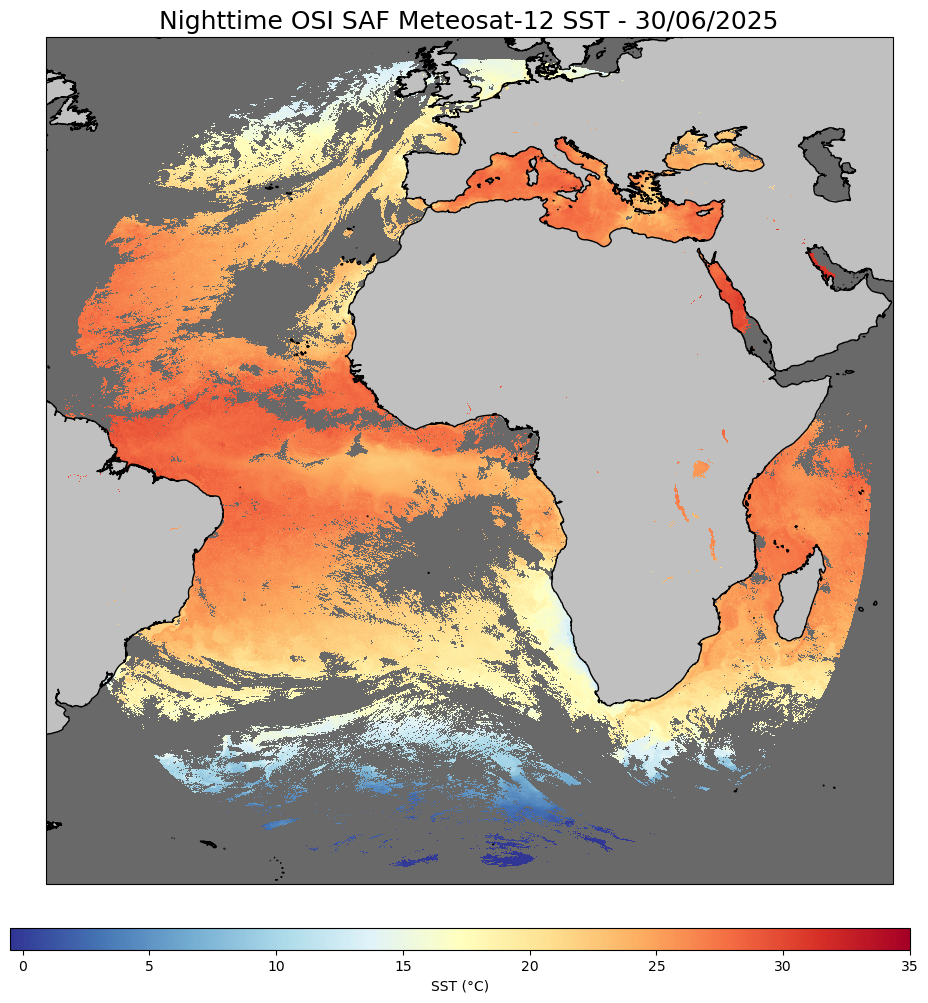

In [16]:
# create a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 11), subplot_kw={'projection': ccrs.PlateCarree()})

# add card features
ax.add_feature(cfeature.LAND, facecolor='silver')
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='dimgrey')

# draw coastline
ax.coastlines('10m')

# create a map of the SST(the SST in Kelvin is here converted in °Celius) 
c = ax.pcolormesh(lon_sat, lat_sat, result_sst[0, :, :]-273.15, cmap='RdYlBu_r', shading='auto')
c.set_clim(-0.5,35)


# add a colorbar
fig.colorbar(c, ax=fig.add_axes([0.3,0.5,0.3,0.1], anchor='S', zorder=-1 ), cax = fig.add_axes((0.13,0.05,0.75,0.02)), orientation='horizontal', label='SST (°C)')

# add a title
ax.set_title('Nighttime OSI SAF Meteosat-12 SST - '+Date_str, fontdict={'fontsize': 18})

# show the map
plt.show()

<div class="alert alert-info" role="alert">

## <a id='section7'></a>7. Mapping the SST anomalies
[Back to top](#TOC-TOP)

</div>

We have to reduce longitude and latitude from the climatology file to compare with the SST.

In [17]:
# reduce the longitudes and latitudes of the climatology file in order to have two files with the same latitude and longitude to be able to compare them
sst_clim1 = dataset_clim.sel(lon=lon_sat, lat=lat_sat, method="nearest")
sst_clim = sst_clim1.variables['analysed_sst'][:]

For each pixel, we can now calculate the deviation between our satellite daily SST value, and the climatology SST.

In [18]:
diff_sst = result_sst - sst_clim

When we have the difference, we can plot it !


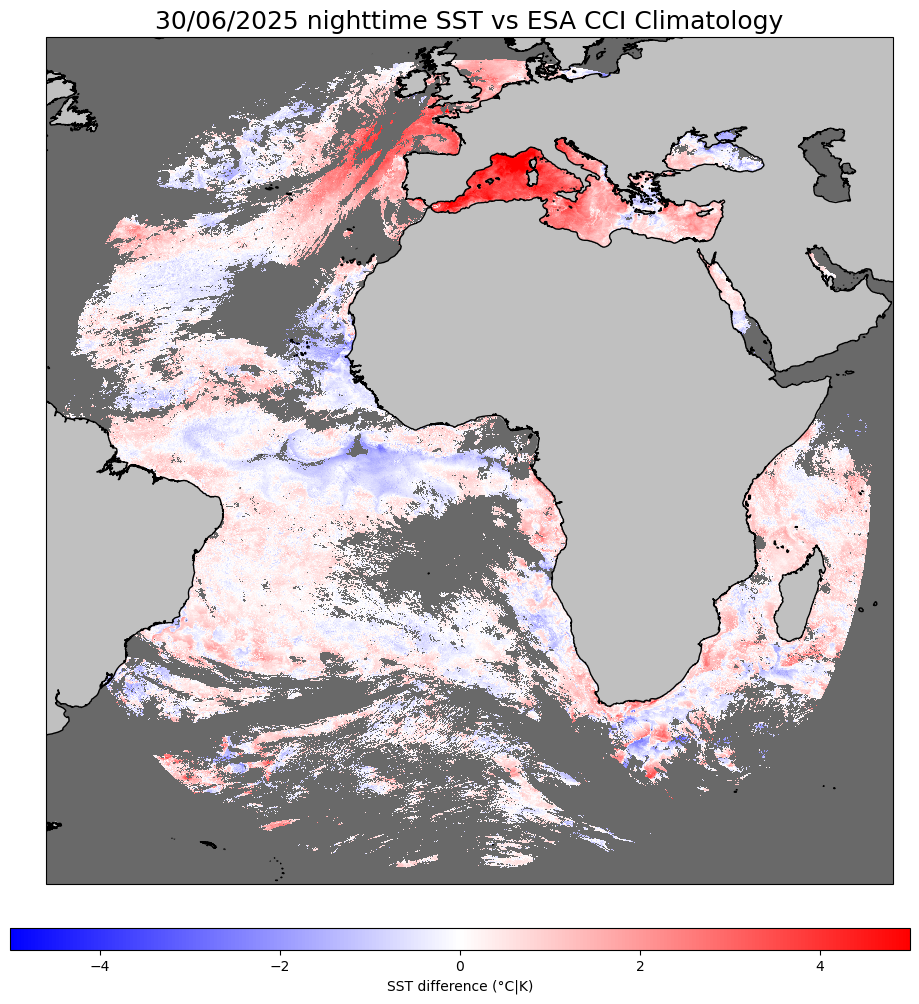

In [19]:
# create a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 11), subplot_kw={'projection': ccrs.PlateCarree()})

# add card features
ax.add_feature(cfeature.LAND, facecolor='silver')
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='dimgrey')

# Draw coastline
ax.coastlines('10m')

# create a map of the temperature difference
c = ax.pcolormesh(lon_sat, lat_sat, diff_sst[0, :, :], cmap='bwr', shading='auto')
c.set_clim(-5,5)

# add a colorbar
fig.colorbar(c, ax=fig.add_axes([0.3,0.5,0.3,0.1], anchor='S', zorder=-1 ), cax = fig.add_axes((0.13,0.05,0.75,0.02)), orientation='horizontal', label='SST difference (°C|K)')

# add a title
ax.set_title(Date_str+' nighttime SST vs ESA CCI Climatology', fontdict={'fontsize': 18})

# show the map
plt.show()

By the end of June 2025, the Western Mediterranean Sea was the theater of an important Marine Heatwave. Localy, on the 30th of June, the deviation from the climatology exceeded +6°C, which saturated the commonly used palette -5/+5 K.<br>
On the contrary, the strong negative and positive deviations spots we see south of South Africa are due to the Agulhas current. This hot water current doesn't take exactly the same path from year to year, causing apparent strong deviation to this type of visualisation.

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="../1_OSI_SAF_sst_introductory/1_1a_OSI_SAF_SST_data_access_IFREMER_FTP.ipynb" target="_blank"><< OSI SAF sea surface temperature Introductory</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>